In [41]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date,timedelta,datetime
import talib
import time
import os
from IPython.display import clear_output
from plotly.subplots import make_subplots
from ta.volume import VolumeWeightedAveragePrice
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import mplfinance as mpf
import matplotlib.pyplot as plt
import datetime as dt
import pandas_ta as ta
from sklearn import metrics
from scipy import stats
end_date = dt.datetime.now()
start_date = '2013-01-01'
start_date_new = datetime.strptime(start_date, "%Y-%m-%d").strftime("%d-%b-%Y")
end_date_new= end_date.strftime("%d-%b-%Y")
start_date_vix= datetime.strptime(start_date, "%Y-%m-%d").strftime("%d-%m-%Y")
end_date_vix= end_date.strftime("%d-%m-%Y")


In [42]:
# Functions used in the code

def vwap(dataframe, label='vwap', window=10, fillna=True):
        dataframe[label] = VolumeWeightedAveragePrice(high=dataframe['High'], low=dataframe['Low'], close=dataframe["Adj Close"], volume=dataframe['Volume'], window=window, fillna=fillna).volume_weighted_average_price()
        return dataframe
def na_rows(df):
  '''
  This functions returns rows 
  where NaN values are present
  '''
  return df[df.isna().any(axis=1)]
def check_adfuller(df):
    # Dickey-Fuller test
    print("NULL HYPOTHESIS: time series is NOT stationary")
    print("ALTERNATE HYPOTHESIS: time series is stationary")
    result = adfuller(df, autolag = 'AIC')
    print('Test statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:' ,result[4])
    if (result[0] > result[4]["5%"]):
        print("Test statistic is greater than 5% critical value, ACCEPT NULL HYPOTHESIS")
    else:
        print("Test statistic is less than 5% critical value, REJECT NULL HYPOTHESIS")

    if result[1] < 0.05:
        print("p-value is less than 0.05, REJECT NULL HYPOTHESIS")
    else:
        print("p-value is greater than 0.05, ACCEPT NULL HYPOTHESIS")
        
def fn_keltner_channels(df,kc_lookback_period=7,KC_mult_high= 1): 
        
        df["KC_basis"]        = talib.SMA(df.Close, kc_lookback_period)
        df["devKC"]           = talib.SMA(ta.TRANGE(df.High,df.Low,df.Close),kc_lookback_period)
        df["KC_upper_high"]   = df.KC_basis + df.devKC * KC_mult_high
        df["KC_lower_high"]   = df.KC_basis - df.devKC * KC_mult_high

        return df
def fn_relative_strength(prices, n=14):

        deltas = np.diff(prices)
        seed = deltas[:n + 1]
        up = seed[seed >= 0].sum() / n
        down = -seed[seed < 0].sum() / n
        rs = up / down
        rsi = np.zeros_like(prices)
        rsi[:n] = 100. - 100. / (1. + rs)

        for i in range(n, len(prices)):
            delta = deltas[i - 1]  # cause the diff is 1 shorter

            if delta > 0:
                upval = delta
                downval = 0.
            else:
                upval = 0.
                downval = -delta

            up = (up * (n - 1) + upval) / n
            down = (down * (n - 1) + downval) / n

            rs = up / down
            rsi[i] = 100. - 100. / (1. + rs)

        return rsi
def convert_date(date_str):
    return datetime.strptime(date_str, '%d-%B-%Y').strftime('%Y-%m-%d')
def remove_outliers(df,z_threshold):
    z_scores = np.abs((df - df.mean()) / df.std())
    outlier_indices = np.any(z_scores > z_threshold, axis=1)
    cleaned_data = df[~outlier_indices]
    return cleaned_data

def SMA(ts, window):
    rmse = []
    for i in tqdm(window):
        rolling_mean = ts.rolling(i).mean().shift(1) # shifting by 1 because mean of last i values will be predicted as (i+1)th prediction
        rmse.append(mean_squared_error(ts.values[i:], rolling_mean.dropna(), squared = False))

    plt.figure()
    plt.plot(window, rmse, "bo-", label = "train rmse")
    plt.legend()
    plt.xlabel("window")
    plt.ylabel("RMSE")
    plt.title("train RMSE wrt window size")
    plt.grid()
    plt.show()
def fn_pivot_point(df,Type='Standard'):
        if Type=='Standard':
            df['PP_standard']=(df['High'].iloc[-1]+df['Low'].iloc[-1]+df['Close'].iloc[-1])/3
            df['R1_standard']=(2*df['PP_standard'])-df['Low'].iloc[-1]
            df['R2_standard']=(df['PP_standard']+(df['High'].iloc[-1]-df['Low'].iloc[-1]))
            df['R3_standard']=(df['High'].iloc[-1]+(2*(df['PP_standard']-df['Low'].iloc[-1])))
            df['S1_standard']=(2*df['PP_standard'])-df['High'].iloc[-1]
            df['S2_standard']=(df['PP_standard']-(df['High'].iloc[-1]-df['Low'].iloc[-1]))
            df['S3_standard']=(df['Low'].iloc[-1]+(2*(df['High'].iloc[-1]-df['PP_standard'])))
            return df
        
        elif Type=='Fibonacci':
            df['PP_fibonacci']=(df['High'].iloc[-1]+df['Low'].iloc[-1]+df['Close'].iloc[-1])/3
            df['R1_fibonacci']=df['PP_fibonacci'] + 0.382 * (df['High'].iloc[-1] - df['Low'].iloc[-1])
            df['R2_fibonacci']=df['PP_fibonacci'] + 0.618 * (df['High'].iloc[-1] - df['Low'].iloc[-1])
            df['R3_fibonacci']=df['PP_fibonacci'] + (df['High'].iloc[-1] - df['Low'].iloc[-1])
            df['S1_fibonacci']=df['PP_fibonacci'] - 0.382 * (df['High'].iloc[-1] - df['Low'].iloc[-1])
            df['S2_fibonacci']=df['PP_fibonacci'] - 0.618 * (df['High'].iloc[-1] - df['Low'].iloc[-1])
            df['S3_fibonacci']=df['PP_fibonacci'] - (df['High'].iloc[-1] - df['Low'].iloc[-1])
            return df
        
        elif Type=='Camarilla':
            df['PP_camarilla']=(df['High'].iloc[-1]+df['Low'].iloc[-1]+df['Close'].iloc[-1])/3
            df['R1_camarilla']=df['Close'] + 1.1 * (df['High'].iloc[-1] - df['Low'].iloc[-1]) / 12
            df['R2_camarilla']=df['Close'] + 1.1 * (df['High'].iloc[-1] - df['Low'].iloc[-1]) / 6
            df['R3_camarilla']=df['Close'] + 1.1 * (df['High'].iloc[-1] - df['Low'].iloc[-1]) / 4
            df['R4_camarilla']=df['Close'] + 1.1 * (df['High'].iloc[-1] - df['Low'].iloc[-1]) / 2
            df['S1_camarilla']=df['Close'] - 1.1 * (df['High'].iloc[-1] - df['Low'].iloc[-1]) / 12
            df['S2_camarilla']=df['Close'] - 1.1 * (df['High'].iloc[-1] - df['Low'].iloc[-1]) / 6
            df['S3_camarilla']=df['Close'] - 1.1 * (df['High'].iloc[-1] - df['Low'].iloc[-1]) / 4
            df['S4_camarilla']=df['Close'] - 1.1 * (df['High'].iloc[-1] - df['Low'].iloc[-1]) / 2
            return df
        
        elif Type=='Classic':
            df['PP_classic']=(df['High'].iloc[-1]+df['Low'].iloc[-1]+df['Close'].iloc[-1])/3
            df['R1_classic']=(2 * df['PP_classic']) - df['Low'].iloc[-1]
            df['R2_classic']=df['PP_classic'] +df['High'].iloc[-1] - df['Low'].iloc[-1]
            df['R3_classic']=df['PP_classic'] +2*(df['High'].iloc[-1] - df['Low'].iloc[-1])
            df['S1_classic']=(2 * df['PP_classic']) - df['High'].iloc[-1]
            df['S2_classic']=df['PP_classic']-df['High'].iloc[-1] + df['Low'].iloc[-1]
            df['S3_classic']=df['PP_classic'] -2*(df['High'].iloc[-1] - df['Low'].iloc[-1])
            return df
        
        elif Type=='Woodies':
            df['PP_woodies']=(df['High'].iloc[-1]+df['Low'].iloc[-1]+2*df['Close'].iloc[-1])/4
            df['R1_woodies']=(2 * df['PP_woodies']) - df['Low'].iloc[-1]
            df['R2_woodies']=df['PP_woodies'] +df['High'].iloc[-1] - df['Low'].iloc[-1]
            df['S1_woodies']=(2 * df['PP_woodies']) - df['High'].iloc[-1]
            df['S2_woodies']=df['PP_woodies']-df['High'].iloc[-1] + df['Low'].iloc[-1]
            return df
        
        elif Type=='DeMarks':
            x=np.where(df['Close'].iloc[-1]<df['Open'].iloc[-1],(df['High'].iloc[-1]+(2*df['Low'].iloc[-1]))+(df['Close'].iloc[-1]),(df['Low'].iloc[-1]+(2*df['High'].iloc[-1])+df['Close'].iloc[-1]))
            df['PP_DeMarks']=x/4
            df['R1_DeMarks']=( x/2) - df['Low'].iloc[-1]
            df['S1_DeMarks']= (x/2) - df['High'].iloc[-1]
            return df
        else:
            print('Incorrect pivot type')
def fn_replace_nan_mean(df):
        missing_data = df.isnull()
        for column in missing_data.columns.values.tolist():
            rolling_mean = df[column].rolling(window=10, min_periods=1).median()
            df[column] = df[column].fillna(rolling_mean)
        return df
def fn_ACF__PACF_autocorrelation(df,lags=30):
        
    # Plot ACF and PACF
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))

    # Plot ACF
    plot_acf(df['Adj Close'], lags=lags, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')

    # Plot PACF
    plot_pacf(df['Adj Close'], lags=lags, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()
def grubbs_test(data, alpha=0.05):
    n = len(data)
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)  # Use ddof=1 for sample standard deviation
    threshold = stats.t.ppf(1 - alpha / (2 * n), n - 2)
    
    max_deviation = max(abs(data - mean))
    G = max_deviation / std_dev
    
    is_outlier = G > threshold
    
    return is_outlier

### OHLC Data with technical indicators

[*********************100%***********************]  1 of 1 completed


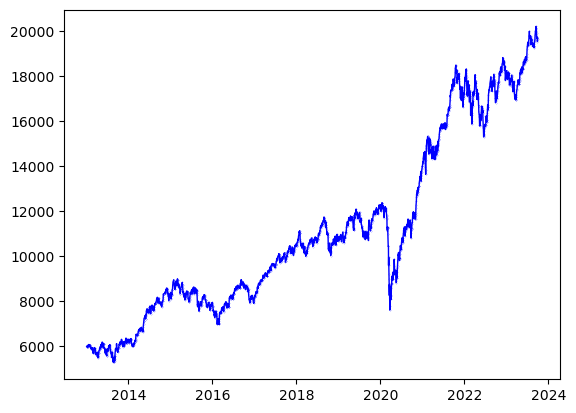

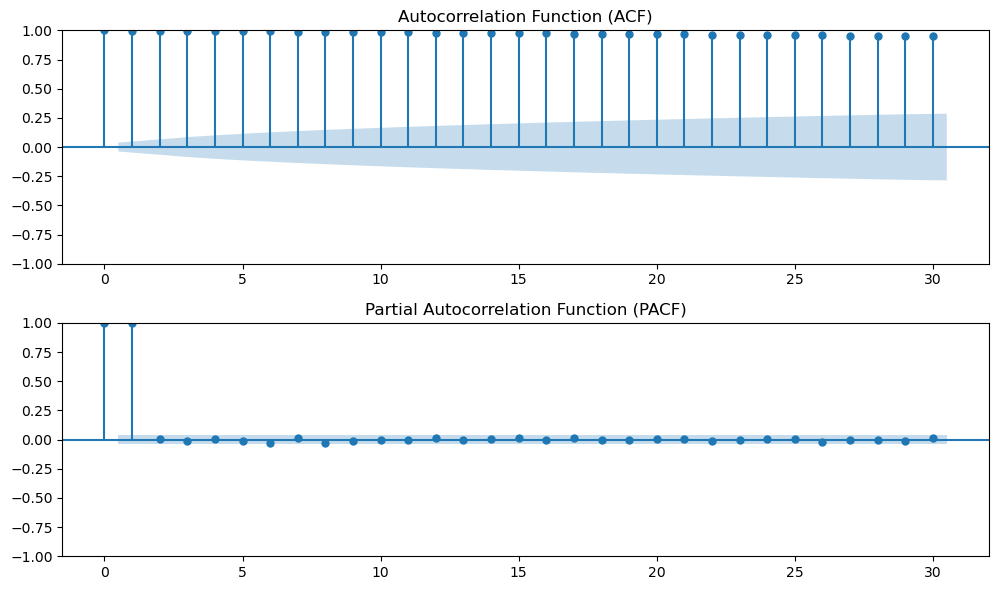

In [43]:

Nifty_OHLC=yf.download('^NSEI',start_date,end_date)
Nifty_OHLC=fn_pivot_point(Nifty_OHLC,Type='Standard')
Nifty_OHLC['rsi'] =fn_relative_strength(Nifty_OHLC['Adj Close'], n=14)
Nifty_OHLC['rsi_change'] =Nifty_OHLC['rsi']-Nifty_OHLC['rsi'].shift(1)
Nifty_OHLC['Daily_return']=Nifty_OHLC['Adj Close'].pct_change() * 100
Nifty_OHLC['EMA']=Nifty_OHLC['Adj Close'].ewm(span=14, adjust=False).mean()
Nifty_OHLC['Open-prev_Close']=Nifty_OHLC['Open']-Nifty_OHLC['Adj Close'].shift(1)
Nifty_OHLC['Close-Open']=Nifty_OHLC['Adj Close']-Nifty_OHLC['Open']
Nifty_OHLC['Close-High']=Nifty_OHLC['Adj Close']-Nifty_OHLC['High']
Nifty_OHLC['Close-Low']=Nifty_OHLC['Adj Close']-Nifty_OHLC['Low']

Nifty_OHLC=vwap(Nifty_OHLC, label='vwap', window=22, fillna=True)

Nifty_OHLC['Log_Return'] = np.log(Nifty_OHLC['Adj Close'] / Nifty_OHLC['Adj Close'].shift(1))
Nifty_OHLC['Momentum']=np.where((Nifty_OHLC['Adj Close'].pct_change()*100)>0.25,1,-1)

Nifty_OHLC['pivotpoint_direction_up']=Nifty_OHLC['Adj Close']-Nifty_OHLC['R1_standard']
Nifty_OHLC['pivotpoint_direction_down']=Nifty_OHLC['Adj Close']-Nifty_OHLC['S1_standard']

period_list=[2,3,5,7,10,15,20]
for p in period_list:
    Nifty_OHLC[f'sma_{p}'] = talib.SMA(Nifty_OHLC['Adj Close'], timeperiod=p)


per_change_list=[2,3,5,7,10,15,20]
for pc in per_change_list:
    Nifty_OHLC[f'sma_slope_{pc}']=Nifty_OHLC[f'sma_{p}'].pct_change(pc) * 100
    Nifty_OHLC[f'close_slope_{pc}']=Nifty_OHLC['Adj Close'].pct_change(pc) * 100
Nifty_OHLC['indicator'] =np.where((Nifty_OHLC['rsi']>Nifty_OHLC['rsi'].shift(1))&(Nifty_OHLC['rsi'].shift(1)>Nifty_OHLC['rsi'].shift(2)),-1,0)
Nifty_OHLC['indicator'] =np.where((Nifty_OHLC['rsi']<Nifty_OHLC['rsi'].shift(1))&(Nifty_OHLC['rsi'].shift(1)<Nifty_OHLC['rsi'].shift(2)),1,Nifty_OHLC['indicator'] )

sti = ta.supertrend(Nifty_OHLC['High'], Nifty_OHLC['Low'], Nifty_OHLC['Close'], length=7, multiplier=3)
Nifty_OHLC=pd.concat([Nifty_OHLC,sti],axis=1)
columns_to_drop = ['SUPERTl_7_3.0', 'SUPERTs_7_3.0']
Nifty_OHLC = Nifty_OHLC.drop(columns=columns_to_drop)
Nifty_OHLC=fn_pivot_point(Nifty_OHLC,Type='Standard')

#plt.plot(Nifty_OHLC['Log_Return'], bins=30, density=True, alpha=0.7)

plt.plot(Nifty_OHLC.index, Nifty_OHLC['Adj Close'], label='Sine Curve', color='blue', linewidth=1, linestyle='-', marker='o', markersize=0.1)
plt.show()
fn_ACF__PACF_autocorrelation(Nifty_OHLC,lags=30)

In [44]:
Nifty_OHLC['indicator'].value_counts()

 0    1205
-1     817
 1     618
Name: indicator, dtype: int64

In [45]:
Nifty_OHLC['Log_Return'].describe()

count    2639.000000
mean        0.000450
std         0.010645
min        -0.139038
25%        -0.004551
50%         0.000692
75%         0.006151
max         0.084003
Name: Log_Return, dtype: float64

In [46]:
grubbs_test(Nifty_OHLC['Log_Return'], alpha=0.05)

False

In [47]:
check_adfuller(Nifty_OHLC['Adj Close'])

NULL HYPOTHESIS: time series is NOT stationary
ALTERNATE HYPOTHESIS: time series is stationary
Test statistic: 0.07634602498326888
p-value: 0.9644085240206031
Critical Values: {'1%': -3.4328369639536587, '5%': -2.8626387516878955, '10%': -2.567354903970076}
Test statistic is greater than 5% critical value, ACCEPT NULL HYPOTHESIS
p-value is greater than 0.05, ACCEPT NULL HYPOTHESIS


### FII DII Data

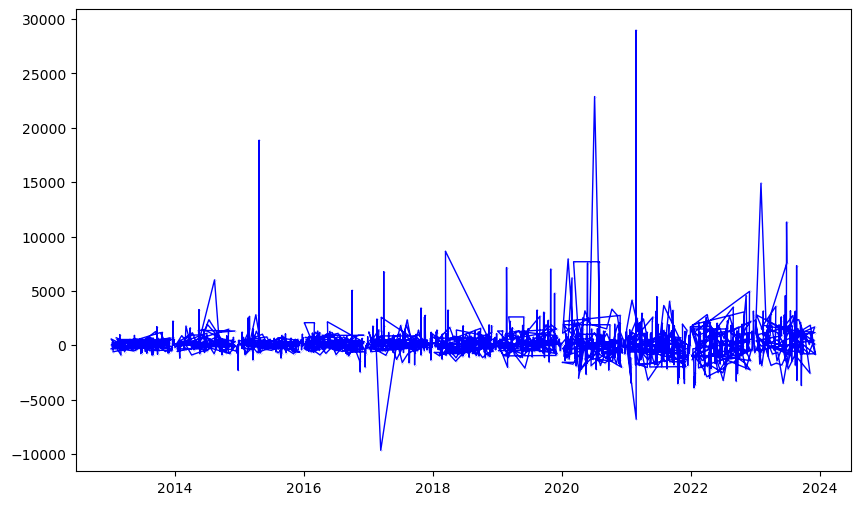

,FII_Gross_Purchase,FII_Gross_Sales,FII_Net,DII_Gross_Purchase,DII_Gross_Sales,DII_Net,Net_ FII_DII,FII_Net_ema,DII_Net_ema,FII_DII_Net_ema
Date,,,,,,,,,,
2013-02-01,2341.67,1234.01,1107.66,1271.09,1688.50,-417.41,690.25,1107.660000,-417.410000,690.250000
2013-03-01,3089.48,1692.11,1397.37,996.46,1902.42,-905.96,491.41,1146.288000,-482.550000,663.738000
2013-04-01,3187.89,2023.48,1164.41,1148.55,1973.95,-825.40,339.01,1148.704267,-528.263333,620.440933
2013-07-01,0.00,0.00,887.38,0.00,0.00,-1028.12,-140.74,1113.861031,-594.910889,518.950142
2013-08-01,3177.07,2289.69,887.38,735.40,1763.52,-1028.12,-140.74,1083.663560,-652.672104,430.991457
...,...,...,...,...,...,...,...,...,...,...
2023-09-25,8510.65,10843.68,-2333.03,8621.77,7042.49,1579.28,-753.75,-1446.240679,856.878975,-589.361704
2023-09-26,8750.81,9444.28,-693.47,7502.47,6787.72,714.75,21.28,-1345.871255,837.928445,-507.942810
2023-09-27,9575.17,9929.52,-354.35,8419.68,8033.40,386.28,31.93,-1213.668421,777.708652,-435.959769


In [49]:
encodings_to_try = ['utf-8', 'latin1', 'ISO-8859-1']

for encoding in encodings_to_try:
    try:
        FII_DII_Data = pd.read_csv('Fii_Dii.csv', encoding=encoding)
        break  # Stop trying encodings if successful
    except UnicodeDecodeError:
        pass
FII_DII_Data = pd.read_csv('Fii_Dii.csv', encoding=encoding)
FII_DII_Data['Date'] = pd.to_datetime(FII_DII_Data['Date'])
FII_DII_Data['FII_Net_ema']= FII_DII_Data['FII_Net'].ewm(span=14, adjust=False).mean()
FII_DII_Data['DII_Net_ema']= FII_DII_Data['DII_Net'].ewm(span=14, adjust=False).mean()
FII_DII_Data['FII_DII_Net_ema']= FII_DII_Data['Net_ FII_DII'].ewm(span=14, adjust=False).mean()

FII_DII_Data.set_index('Date', inplace=True)

plt.figure(figsize=(10, 6))

#plt.plot(FII_DII_Data.index , FII_DII_Data['FII_Net'], label='FII_NET', marker='o')
#plt.plot(FII_DII_Data.index  , FII_DII_Data['DII_Net'], label='DII_NET', marker='o')
plt.plot(FII_DII_Data.index, FII_DII_Data['Net_ FII_DII'], label='Sine Curve', color='blue', linewidth=1, linestyle='-', marker='o', markersize=0.1)
plt.show()

FII_DII_Data

#### PE,PB,DIV ratio data

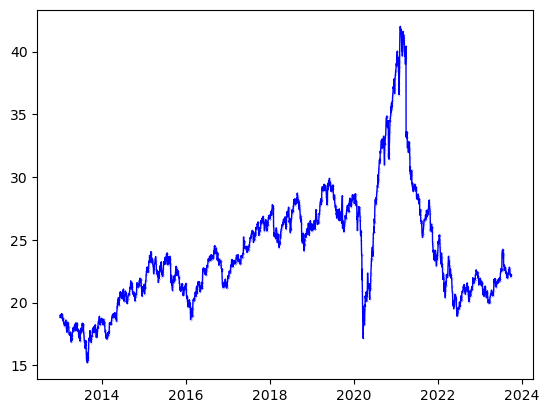

In [50]:
from nsepython import *
import pandas as pd
from datetime import date,timedelta,datetime
symbol = "NIFTY 50"
pe_pb_data=pd.DataFrame(index_pe_pb_div(symbol,start_date_new,end_date_new))
pe_pb_data['Date'] = pd.to_datetime(pe_pb_data['DATE'])
pe_pb_data.set_index('Date', inplace=True)
pe_pb_data['pe'] = pd.to_numeric(pe_pb_data['pe'], errors='coerce')
columns_to_drop = ['Index Name','pb','divYield','DATE']
pe_pb_data = pe_pb_data.drop(columns=columns_to_drop)
pe_pb_data
plt.plot(pe_pb_data.index, pe_pb_data['pe'], label='Sine Curve', color='blue', linewidth=1, linestyle='-', marker='o', markersize=0.1)
plt.show()

### Crude oil prices

[*********************100%***********************]  1 of 1 completed


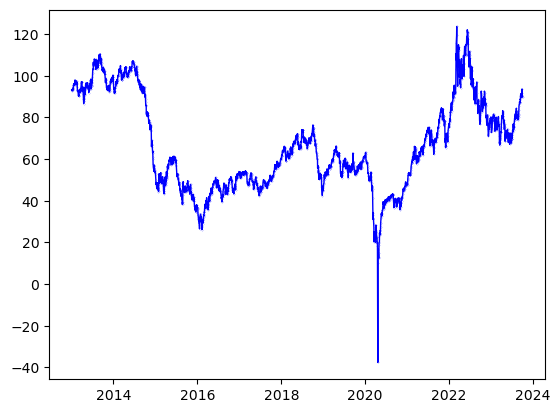

In [51]:
crude_prices=yf.download('CL=F',start_date,end_date)
vwap(crude_prices, label='vwap', window=3, fillna=True)
new_column_names = {'Open': 'crude_Open', 'High': 'crude_High','Low': 'crude_Low', 'Close': 'crude_Close','Adj Close': 'crude_Adj Close','Volume': 'crude_Volume','vwap':'crude_VWAP'}
crude_prices.rename(columns=new_column_names, inplace=True)
crude_prices['crude_Daily_return']= crude_prices['crude_Adj Close'].pct_change() * 100
period_list=[2,3,5,7,10,15,20]
for p in period_list:
    crude_prices[f'crude_prices_sma_{p}'] = talib.SMA(crude_prices['crude_Adj Close'], timeperiod=p)
crude_prices['crude_Dailyreturn_EMA']=crude_prices['crude_Daily_return'].ewm(span=14, adjust=False).mean()
crude_prices
plt.plot(crude_prices.index,crude_prices['crude_Adj Close'], label='Sine Curve', color='blue', linewidth=1, linestyle='-', marker='o', markersize=0.1)
plt.show()

### USD-INR Prices

[*********************100%***********************]  1 of 1 completed


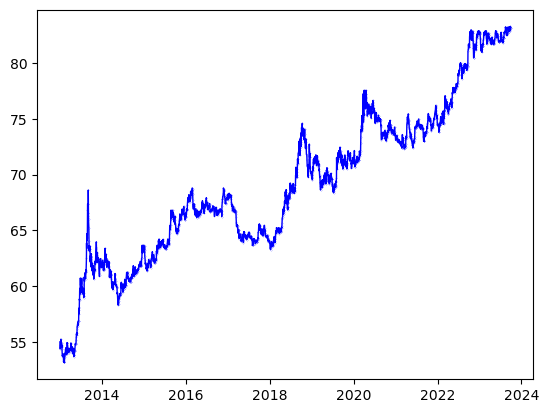

In [52]:
USD_INR=yf.download('USDINR=X',start_date,end_date)
new_column_names = {'Open': 'USD_INR_Open', 'High': 'USD_INR_High','Low': 'USD_INR_Low', 'Close': 'USD_INR_Close','Adj Close': 'USD_INR_Adj Close','Volume': 'USD_INR_Volume'}
USD_INR.rename(columns=new_column_names, inplace=True)
USD_INR['usdinr_%Change']= USD_INR['USD_INR_Adj Close'].pct_change() * 100
USD_INR['USD_INR_Dailyreturn_EMA']=USD_INR['usdinr_%Change'].ewm(span=14, adjust=False).mean()
USD_INR
plt.plot(USD_INR.index,USD_INR['USD_INR_Adj Close'], label='Sine Curve', color='blue', linewidth=1, linestyle='-', marker='o', markersize=0.1)
plt.show()

### Gold prices

[*********************100%***********************]  1 of 1 completed


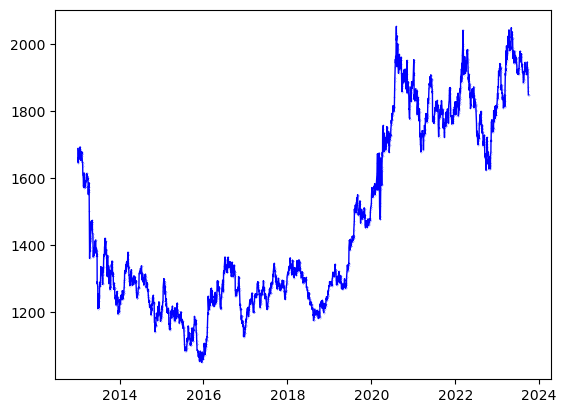

In [53]:
Gold_price=yf.download('GC=F',start_date,end_date)
vwap(Gold_price, label='vwap', window=3, fillna=True)
new_column_names = {'Open': 'Gold_price_Open', 'High': 'Gold_price_High','Low': 'Gold_price_Low', 'Close': 'Gold_price_Close','Adj Close': 'Gold_price_Adj Close','Volume': 'Gold_price_Volume','vwap':'Gold_price_VWAP'}
Gold_price.rename(columns=new_column_names, inplace=True)
Gold_price['Gold_price_Adj Close_%Change']= Gold_price['Gold_price_Adj Close'].pct_change() * 100
Gold_price['Gold_price_Dailyreturn_EMA']=Gold_price['Gold_price_Adj Close_%Change'].ewm(span=14, adjust=False).mean()
Gold_price
plt.plot(Gold_price.index,Gold_price['Gold_price_Adj Close'], label='Sine Curve', color='blue', linewidth=1, linestyle='-', marker='o', markersize=0.1)
plt.show()

### S&P 500

[*********************100%***********************]  1 of 1 completed


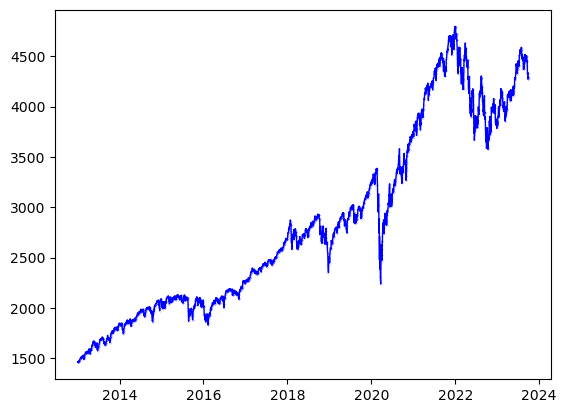

In [54]:
SP500=yf.download('^GSPC',start_date,end_date)
vwap(SP500, label='vwap', window=3, fillna=True)
new_column_names = {'Open': 'SP500_Open', 'High': 'SP500_High','Low': 'SP500_Low', 'Close': 'SP500_Close','Adj Close': 'SP500_Adj Close','Volume': 'SP500_Volume','vwap':'SP500_VWAP'}
SP500.rename(columns=new_column_names, inplace=True)
SP500['SP500_Adj Close_%Change']= SP500['SP500_Adj Close'].pct_change() * 100
SP500['SP500_Adj Close_EMA']=SP500['SP500_Adj Close'].ewm(span=14, adjust=False).mean()
SP500
plt.plot(SP500.index,SP500['SP500_Adj Close'], label='Sine Curve', color='blue', linewidth=1, linestyle='-', marker='o', markersize=0.1)
plt.show()

### India VIX

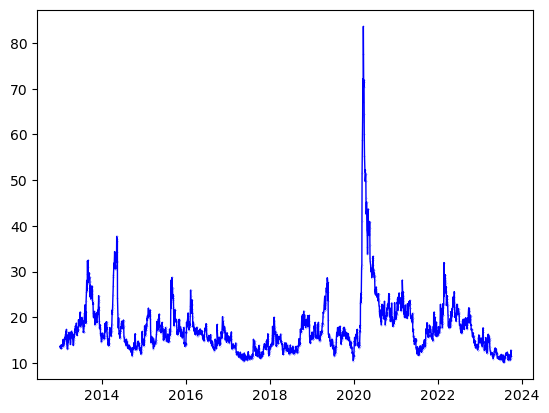

In [55]:
from nselib import capital_market
vix_data = capital_market.india_vix_data(start_date_vix,end_date_vix)
new_column_names = {'TIMESTAMP': 'Date','CLOSE_INDEX_VAL':'INDIAVIX_Close','PREV_CLOSE':'INDIAVIX_PREV_CLOSE'}
vix_data.rename(columns=new_column_names, inplace=True)
vix_data['Date'] = pd.to_datetime(vix_data['Date'])
vix_data.set_index('Date',inplace=True)
columns_to_drop = ['INDEX_NAME','INDIAVIX_PREV_CLOSE']
vix_data = vix_data.drop(columns=columns_to_drop)
vix_data['vix_Dailyreturn_EMA']=vix_data['VIX_PERC_CHG'].ewm(span=14, adjust=False).mean()
vix_data
plt.plot(vix_data.index,vix_data['INDIAVIX_Close'], label='Sine Curve', color='blue', linewidth=1, linestyle='-', marker='o', markersize=0.1)
plt.show()

### Top 10 stocks

In [38]:
ticker_list=['HDFCBANK.NS','RELIANCE.NS','ICICIBANK.NS','INFY.NS','ITC.NS','TCS.NS','LT.NS','KOTAKBANK.NS','AXISBANK.NS','SBIN.NS']
df_Top_stocks=pd.DataFrame()
for ticker in ticker_list:
    df=yf.download(ticker,start_date,end_date)
    df['daily_return'] =df['Adj Close'].pct_change() * 100
    df_Top_stocks[f'{ticker}_daily_return']=df['daily_return']
    clear_output(wait=False)
df_Top_stocks

,HDFCBANK.NS_daily_return,RELIANCE.NS_daily_return,ICICIBANK.NS_daily_return,INFY.NS_daily_return,ITC.NS_daily_return,TCS.NS_daily_return,LT.NS_daily_return,KOTAKBANK.NS_daily_return,AXISBANK.NS_daily_return,SBIN.NS_daily_return
Date,,,,,,,,,,
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,0.416370,0.862376,1.342296,0.015115,-0.644017,-0.067214,1.517054,1.069333,1.772206,0.993214
2013-01-03,-0.581933,1.509522,-0.166075,1.242886,-0.648202,1.369406,-0.769925,-0.304463,0.223503,0.859002
2013-01-04,-0.585359,0.127804,0.883051,0.498303,-0.405576,1.452445,-0.540680,-0.717685,-0.791366,0.610927
2013-01-07,-1.641264,-0.609175,-0.021131,1.074669,-1.186273,-0.334821,-2.447812,-0.269123,-0.442377,-0.768076
...,...,...,...,...,...,...,...,...,...,...
2023-09-25,0.088254,-0.615724,0.636640,-1.470441,-0.112841,-0.735366,-0.548227,1.591282,0.068747,-0.685453
2023-09-26,0.434358,0.087592,-0.799913,-0.915782,-0.033889,0.239018,0.346255,-1.137640,-0.471072,0.058924
2023-09-27,-0.702374,1.126997,-0.590285,0.434736,1.514291,0.100402,1.802544,0.059523,1.089575,-0.782306


In [56]:
# all data combined in one dataframe
concatenated_df = pd.concat([Nifty_OHLC, FII_DII_Data,pe_pb_data,crude_prices,USD_INR,Gold_price,SP500,vix_data,df_Top_stocks], axis=1)
#concatenated_df = pd.concat([Nifty_OHLC,SP500,vix_data,FII_DII_Data], axis=1)
#concatenated_df=fn_replace_nan_mean(concatenated_df)
concatenated_df.dropna(inplace=True,axis=0)
column_names_list = concatenated_df.columns.tolist()
# Previous day values used to predict current day price

#columns_to_shift = ['Adj Close','Volume','vwap','KC_basis','devKC','rsi','FII_Net','DII_Net','pe','pb','crude_Adj Close','USD_INR_Adj Close','Gold_price_Adj Close','SP500_Adj Close','HDFCBANK.NS', 'RELIANCE.NS','ICICIBANK.NS','INFY.NS','ITC.NS','TCS.NS','LT.NS','KOTAKBANK.NS','AXISBANK.NS','SBIN.NS']
#columns_to_shift = ['Daily_return','VWAP_Daily_return','Dailyreturn_EMA','crude_Dailyreturn_EMA','USD_INR_Dailyreturn_EMA','Gold_price_Dailyreturn_EMA','SP500_Dailyreturn_EMA','rsi_%change','FII_Net_ema','DII_Net_ema','pe','vix_Dailyreturn_EMA']
#columns_to_shift = ['crude_Daily_return','prediction_1','prediction_2','rsi','usdinr_%Change','Gold_price_Adj Close_%Change','SP500_Adj Close_%Change','VIX_PERC_CHG','HDFCBANK.NS_daily_return','ICICIBANK.NS_daily_return']
columns_to_shift=column_names_list
# Number of previous days to shift
num_days = 1
new_columns_list=[]
# Create previous day columns using a loop
for column in columns_to_shift:
    for i in range(1, num_days + 1):
        concatenated_df[f'{column}_prev_{i}'] = concatenated_df[column].shift(i)
        new_columns_list.append(f'{column}_prev_{i}')

#sns.regplot(x="Dailyreturn_EMA_prev_1", y="Daily_return", data=concatenated_df)
#plt.ylim(0,)
#concatenated_df[['Dailyreturn_EMA_prev_1','Daily_return']].corr()
concatenated_df.dropna(inplace=True,axis=0)
corr = concatenated_df[concatenated_df.columns.tolist()].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)
corr.to_csv('corr.csv')
concatenated_df.to_csv('y.csv')

In [57]:
new_columns_list

['Open_prev_1',
 'High_prev_1',
 'Low_prev_1',
 'Close_prev_1',
 'Adj Close_prev_1',
 'Volume_prev_1',
 'PP_standard_prev_1',
 'R1_standard_prev_1',
 'R2_standard_prev_1',
 'R3_standard_prev_1',
 'S1_standard_prev_1',
 'S2_standard_prev_1',
 'S3_standard_prev_1',
 'rsi_prev_1',
 'rsi_change_prev_1',
 'Daily_return_prev_1',
 'EMA_prev_1',
 'Open-prev_Close_prev_1',
 'Close-Open_prev_1',
 'Close-High_prev_1',
 'Close-Low_prev_1',
 'vwap_prev_1',
 'Log_Return_prev_1',
 'Momentum_prev_1',
 'pivotpoint_direction_up_prev_1',
 'pivotpoint_direction_down_prev_1',
 'sma_2_prev_1',
 'sma_3_prev_1',
 'sma_5_prev_1',
 'sma_7_prev_1',
 'sma_10_prev_1',
 'sma_15_prev_1',
 'sma_20_prev_1',
 'sma_slope_2_prev_1',
 'close_slope_2_prev_1',
 'sma_slope_3_prev_1',
 'close_slope_3_prev_1',
 'sma_slope_5_prev_1',
 'close_slope_5_prev_1',
 'sma_slope_7_prev_1',
 'close_slope_7_prev_1',
 'sma_slope_10_prev_1',
 'close_slope_10_prev_1',
 'sma_slope_15_prev_1',
 'close_slope_15_prev_1',
 'sma_slope_20_prev_1',


### Logistic regression to check classification

Training Accuracy: 0.69
Testing Accuracy: 0.70
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.70      0.88      0.78       533
         1.0       0.69      0.41      0.52       345

    accuracy                           0.70       878
   macro avg       0.69      0.65      0.65       878
weighted avg       0.69      0.70      0.68       878



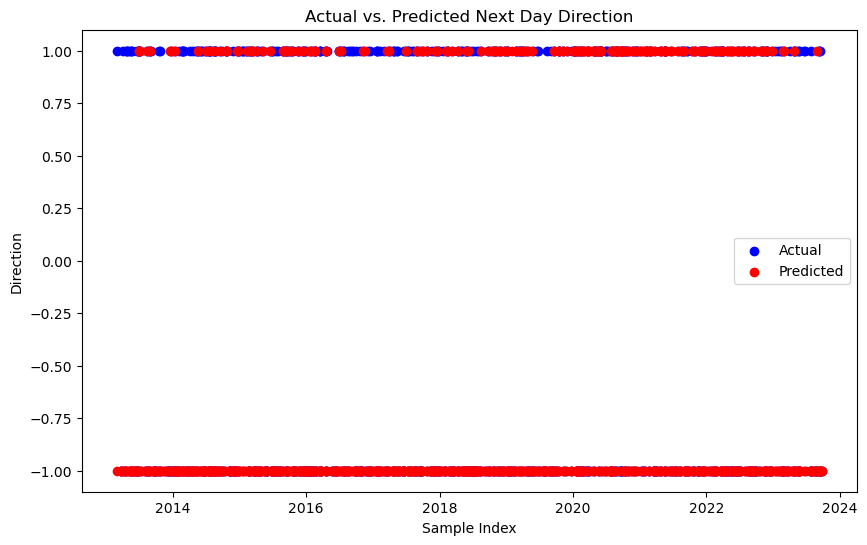

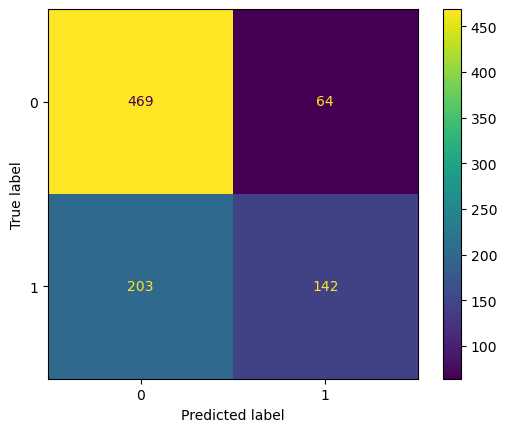

Accuracy: 0.6958997722095672


In [70]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

data = concatenated_df

#features = ['Daily_return_prev_1','FII_DII_Net_ema_prev_1','vwap_prev_1','pivotpoint_direction_up_prev_1','pivotpoint_direction_down_prev_1','SP500_VWAP_prev_1','rsi_prev_1','vwap_prev_1','EMA_prev_1','SP500_Adj Close_%Change_prev_1','Net_ FII_DII_prev_1','sma_slope_90_90_prev_1','INDIAVIX_PREV_CLOSE']
features = [
   'Open-prev_Close',
 'Close-Open_prev_1',
 'Close-High_prev_1',
 'Close-Low_prev_1',
 'rsi_prev_1',
 'indicator_prev_1',
 'Daily_return_prev_1',
 'sma_3_prev_1',
 'sma_7_prev_1',
 'sma_10_prev_1',
 'sma_15_prev_1',          
 'sma_20_prev_1',
 'sma_slope_20_prev_1',
 'close_slope_20_prev_1',
 'SUPERTd_7_3.0_prev_1',
 'FII_Net_ema_prev_1',
 'DII_Net_ema_prev_1',
 'pe_prev_1',
 'crude_VWAP_prev_1',
 'crude_Daily_return_prev_1',
 'USD_INR_Adj Close_prev_1',
 'Gold_price_Volume_prev_1',
 'Gold_price_VWAP_prev_1',
 'SP500_VWAP_prev_1',
 'SP500_Adj Close_%Change_prev_1',
 'INDIAVIX_Close_prev_1',
 'RELIANCE.NS_daily_return_prev_1',
 'ICICIBANK.NS_daily_return_prev_1',
 'INFY.NS_daily_return_prev_1'
 ]  

target = 'Momentum'  # 'up=1', 'down=-1', 'flat'

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.4, random_state=42)

# Prepare the feature matrices and target vectors
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

#Standardisation of model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the logistic regression model
model = LogisticRegression(C=200, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2', random_state=0,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

model.fit(X_train_scaled, y_train)

# Make predictions on the test set
predictions = model.predict(X_test_scaled)

train_accuracy = model.score(X_train_scaled, y_train)
test_accuracy = model.score(X_test_scaled, y_test)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")
# Evaluate the model
print("Classification Report:\n", classification_report(y_test, predictions))

# You can also use the trained model to make predictions for new data
# new_data = pd.DataFrame(...)  # Prepare new data for prediction
# new_predictions = model.predict(new_data[features])
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index, y_test, color='blue', label='Actual')
plt.scatter(y_test.index, predictions, color='red', label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Direction')
plt.title('Actual vs. Predicted Next Day Direction')
plt.legend()
plt.show()
m = metrics.confusion_matrix(y_test,predictions)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m)
disp.plot()
plt.show()
accuracy = np.mean(predictions == y_test)
print('Accuracy:', accuracy)
result_df=pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
result_df.to_csv('result.csv')

In [71]:
model.classes_

array([-1.,  1.])

In [72]:
coefficients = model.coef_
intercept = model.intercept_

In [73]:
print(f"y = {coefficients[0][0]} * x + {intercept[0]}")

y = 0.9503089143217082 * x + -0.4708776018977569


In [74]:
model.predict_proba(X_test_scaled)

array([[0.61245612, 0.38754388],
       [0.49834235, 0.50165765],
       [0.77588109, 0.22411891],
       ...,
       [0.67765468, 0.32234532],
       [0.82253646, 0.17746354],
       [0.63246203, 0.36753797]])

In [93]:
concatenated_df['Date'] = concatenated_df.index
selected_columns = ['Open-prev_Close', 'Close-Open_prev_1', 'Close-High_prev_1', 'Close-Low_prev_1', 'rsi_prev_1', 'indicator_prev_1', 'Daily_return_prev_1', 'sma_3_prev_1', 'sma_7_prev_1', 'sma_10_prev_1', 'sma_15_prev_1', 'sma_20_prev_1', 'sma_slope_20_prev_1', 'close_slope_20_prev_1', 'SUPERTd_7_3.0_prev_1', 'FII_Net_ema_prev_1', 'DII_Net_ema_prev_1', 'pe_prev_1', 'crude_VWAP_prev_1', 'crude_Daily_return_prev_1', 'USD_INR_Adj Close_prev_1', 'Gold_price_Volume_prev_1', 'Gold_price_VWAP_prev_1', 'SP500_VWAP_prev_1', 'SP500_Adj Close_%Change_prev_1', 'INDIAVIX_Close_prev_1', 'RELIANCE.NS_daily_return_prev_1', 'ICICIBANK.NS_daily_return_prev_1', 'INFY.NS_daily_return_prev_1']

last_row_data = concatenated_df.loc['2023-09-13 00:00:00', selected_columns]
last_row_data
previous_day_factors = np.array([last_row_data])
predicted_nifty_direction = model.predict(previous_day_factors)
predicted_nifty_direction

array([-1.])

array([-1.])

## Interpretation

## The model's overall accuracy is currently at 77%. To provide further details, it has achieved   an accuracy of 86% in predicting the "down" class and 41% for the "up" class

Precision: Precision is the ratio of correctly predicted positive observations to the total predicted positives for a class. In other words, it measures how many of the predicted positive cases were actually true positives. Higher precision indicates fewer false positives.

Recall (Sensitivity or True Positive Rate): Recall is the ratio of correctly predicted positive observations to the all observations in the actual class. It measures how well the model is capturing the positive cases. Higher recall indicates fewer false negatives.

F1-Score: The F1-score is the harmonic mean of precision and recall. It provides a balanced measure between precision and recall. It is useful when you have imbalanced classes.

Support: The number of occurrences of each class in the true responses.

Accuracy: The overall accuracy of the model, calculated as the ratio of correctly predicted observations to the total observations.

Macro Avg: The average of precision, recall, and F1-score across all classes, without considering class imbalance.

Weighted Avg: The weighted average of precision, recall, and F1-score, where the weights are based on the number of occurrences of each class.

In [ ]:
features = ['Open',
   'Open-Close',
 'Close-Open_prev_1',
 'Close-High_prev_1',
 'Close-Low_prev_1',
 'rsi_prev_1',
 'indicator_prev_1',
 'Daily_return_prev_1',
 'sma_3_prev_1',
 'sma_7_prev_1',
 'sma_10_prev_1',
 'sma_15_prev_1',          
 'sma_20_prev_1',
 'sma_slope_20_prev_1',
 'close_slope_20_prev_1',
 'SUPERTd_7_3.0_prev_1',
 'FII_Net_ema_prev_1',
 'DII_Net_ema_prev_1',
 'pe_prev_1',
 'crude_VWAP_prev_1',
 'crude_Daily_return_prev_1',
 'USD_INR_Adj Close_prev_1',
 'Gold_price_Volume_prev_1',
 'Gold_price_VWAP_prev_1',
 'SP500_VWAP_prev_1',
 'SP500_Adj Close_%Change_prev_1',
 'INDIAVIX_Close_prev_1',
 'RELIANCE.NS_daily_return_prev_1',
 'ICICIBANK.NS_daily_return_prev_1',
 'INFY.NS_daily_return_prev_1'
 ]  

In [ ]:
'Open',
   'Open-Close',
 'Close-Open_prev_1',
 'Close-High_prev_1',
 'Close-Low_prev_1',
 'rsi_prev_1',
 'SUPERTd_7_3.0_prev_1',
'FII_Net_ema_prev_1',
 'DII_Net_ema_prev_1',
  'INDIAVIX_Close_prev_1',          
 'RELIANCE.NS_daily_return_prev_1',
 'ICICIBANK.NS_daily_return_prev_1',
 'INFY.NS_daily_return_prev_1'